# MAGIC04 - MAGIC Gamma Telescope
## Data are MC generated to simulate registration of high energy gamma particles in an atmospheric Cherenkov telescope

### Dataset Information

### Additional Information

The data are MC generated (see below) to simulate registration of high energy gamma particles in a ground-based atmospheric Cherenkov gamma telescope using the imaging technique. Cherenkov gamma telescope observes high energy gamma rays, taking advantage of the radiation emitted by charged particles produced inside the electromagnetic showers initiated by the gammas, and developing in the atmosphere. This Cherenkov radiation (of visible to UV wavelengths) leaks through the atmosphere and gets recorded in the detector, allowing reconstruction of the shower parameters. The available information consists of pulses left by the incoming Cherenkov photons on the photomultiplier tubes, arranged in a plane, the camera. Depending on the energy of the primary gamma, a total of few hundreds to some 10000 Cherenkov photons get collected, in patterns (called the shower image), allowing to discriminate statistically those caused by primary gammas (signal) from the images of hadronic showers initiated by cosmic rays in the upper atmosphere (background).

Typically, the image of a shower after some pre-processing is an elongated cluster. Its long axis is oriented towards the camera center if the shower axis is parallel to the telescope's optical axis, i.e. if the telescope axis is directed towards a point source. A principal component analysis is performed in the camera plane, which results in a correlation axis and defines an ellipse. If the depositions were distributed as a bivariate Gaussian, this would be an equidensity ellipse. The characteristic parameters of this ellipse (often called Hillas parameters) are among the image parameters that can be used for discrimination. The energy depositions are typically asymmetric along the major axis, and this asymmetry can also be used in discrimination. There are, in addition, further discriminating characteristics, like the extent of the cluster in the image plane, or the total sum of depositions.

The data set was generated by a Monte Carlo program, Corsika, described in:

    D. Heck et al., CORSIKA, A Monte Carlo code to simulate extensive air showers,
    Forschungszentrum Karlsruhe FZKA 6019 (1998).

http://rexa.info/paper?id=ac6e674e9af20979b23d3ed4521f1570765e8d68

The program was run with parameters allowing to observe events with energies down to below 50 GeV.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import PowerTransformer
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

## Exploratory Data Analysis

In [2]:
data = pd.read_csv('magic04.data',header=None)
data.columns=['fLength','fWidth','fSize','fConc','fConc1','fAsym','fM3Long','fM3Trans','fAlpha','fDist','class']
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19020 entries, 0 to 19019
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   fLength   19020 non-null  float64
 1   fWidth    19020 non-null  float64
 2   fSize     19020 non-null  float64
 3   fConc     19020 non-null  float64
 4   fConc1    19020 non-null  float64
 5   fAsym     19020 non-null  float64
 6   fM3Long   19020 non-null  float64
 7   fM3Trans  19020 non-null  float64
 8   fAlpha    19020 non-null  float64
 9   fDist     19020 non-null  float64
 10  class     19020 non-null  object 
dtypes: float64(10), object(1)
memory usage: 1.6+ MB


In [3]:
# Corroborando que no hayan datos faltantes
pd.DataFrame(data.isnull().sum(),columns=['Missing_values'])

,Missing_values
fLength,0
fWidth,0
fSize,0
fConc,0
fConc1,0
fAsym,0
fM3Long,0
fM3Trans,0
fAlpha,0
fDist,0


In [4]:
#%% DATA QUALITY REPORT
def dqr(data):
    # List of database variables
    cols = pd.DataFrame(list(data.columns.values),
                           columns=['Names'],
                           index=list(data.columns.values))
    # List of data types
    dtyp = pd.DataFrame(data.dtypes,columns=['Type'])
    # List of missing data
    # List of present data
    presval = pd.DataFrame(data.count(),
                                  columns=['Present_values'])
    # List of unique values
    unival = pd.DataFrame(columns=['Unique_values'])
    # List of min values
    minval = pd.DataFrame(columns=['Min_value'])
    # List of max values
    maxval = pd.DataFrame(columns=['Max_value'])
    for col in list(data.columns.values):
        unival.loc[col] = [data[col].nunique()]
        try:
            minval.loc[col] = [data[col].min()]
            maxval.loc[col] = [data[col].max()]
        except:
            pass
    
    # Join the tables and return the result
    return cols.join(dtyp).join(presval).join(unival).join(minval).join(maxval)

#%% Obtaining the data quality report
report = dqr(data)
report

,Names,Type,Present_values,Unique_values,Min_value,Max_value
fLength,fLength,float64,19020,18643,4.2835,334.177
fWidth,fWidth,float64,19020,18200,0.0,256.382
fSize,fSize,float64,19020,7228,1.9413,5.3233
fConc,fConc,float64,19020,6410,0.0131,0.893
fConc1,fConc1,float64,19020,4421,0.0003,0.6752
fAsym,fAsym,float64,19020,18704,-457.9161,575.2407
fM3Long,fM3Long,float64,19020,18693,-331.78,238.321
fM3Trans,fM3Trans,float64,19020,18390,-205.8947,179.851
fAlpha,fAlpha,float64,19020,17981,0.0,90.0
fDist,fDist,float64,19020,18437,1.2826,495.561


In [5]:
data

,fLength,fWidth,fSize,fConc,fConc1,fAsym,fM3Long,fM3Trans,fAlpha,fDist,class
0,28.7967,16.0021,2.6449,0.3918,0.1982,27.7004,22.0110,-8.2027,40.0920,81.8828,g
1,31.6036,11.7235,2.5185,0.5303,0.3773,26.2722,23.8238,-9.9574,6.3609,205.2610,g
2,162.0520,136.0310,4.0612,0.0374,0.0187,116.7410,-64.8580,-45.2160,76.9600,256.7880,g
3,23.8172,9.5728,2.3385,0.6147,0.3922,27.2107,-6.4633,-7.1513,10.4490,116.7370,g
4,75.1362,30.9205,3.1611,0.3168,0.1832,-5.5277,28.5525,21.8393,4.6480,356.4620,g
...,...,...,...,...,...,...,...,...,...,...,...
19015,21.3846,10.9170,2.6161,0.5857,0.3934,15.2618,11.5245,2.8766,2.4229,106.8258,h
19016,28.9452,6.7020,2.2672,0.5351,0.2784,37.0816,13.1853,-2.9632,86.7975,247.4560,h
19017,75.4455,47.5305,3.4483,0.1417,0.0549,-9.3561,41.0562,-9.4662,30.2987,256.5166,h
19018,120.5135,76.9018,3.9939,0.0944,0.0683,5.8043,-93.5224,-63.8389,84.6874,408.3166,h


In [6]:
data = data.replace('g',0).replace('h',1)
data['class'] = data['class'].astype('int8')

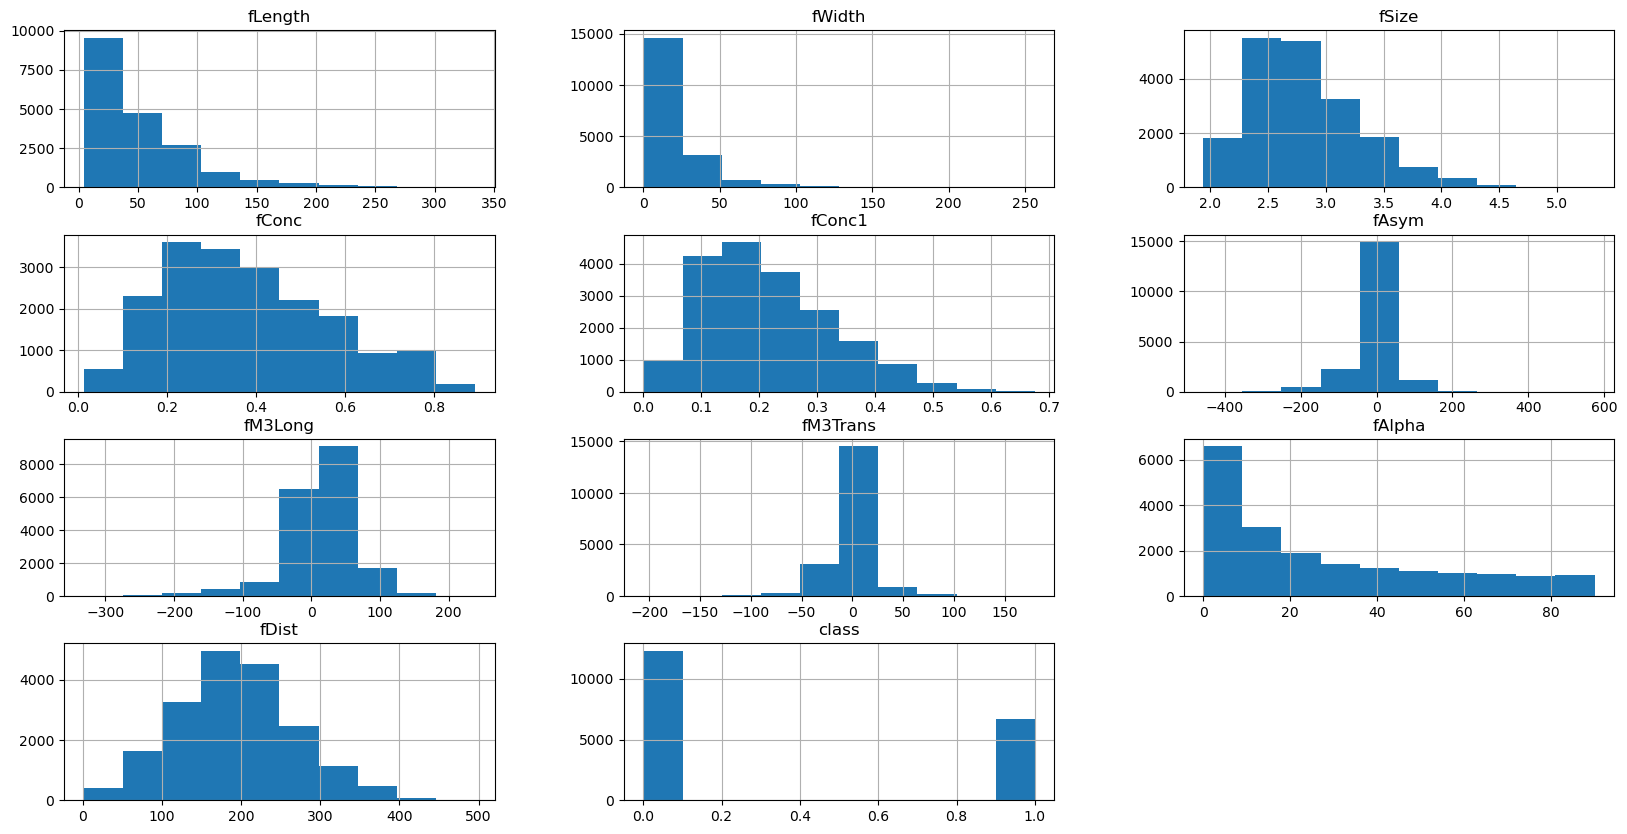

In [7]:
data.hist(figsize=(20,10));

In [8]:
def discard_correlated_variables(data, threshold=0.7):
    """
    Discard correlated variables using a heuristic approach.

    Parameters:
    - data (numpy.ndarray): The input data where rows represent samples and columns represent variables.
    - threshold (float): The correlation threshold to consider when discarding variables.

    Returns:
    - selected_features (list): A list of indices of the selected features.
    """
    
    d={}
    for i in list(range(data.shape[1])):
        d[i]= data.columns[i]
    
    
    
    # Step 1: Calculate the correlation matrix
    correlation_matrix = np.corrcoef(data, rowvar=False)
    
    # Initialize a list to keep track of the selected features
    selected_features = list(range(data.shape[1]))
    
    while True:
        # Step 2: Find the pair of variables with the highest correlation
        max_corr = 0
        pair_to_remove = None
        
        for i in range(len(selected_features)):
            for j in range(i + 1, len(selected_features)):
                feature_i = selected_features[i]
                feature_j = selected_features[j]
                correlation = abs(correlation_matrix[feature_i][feature_j])
                
                if correlation > max_corr:
                    max_corr = correlation
                    pair_to_remove = (feature_i, feature_j)
        if max_corr < threshold:
            break
        
        # Check if a pair was found
        if pair_to_remove is None:
            break
        
        # Step 3: Calculate the average correlation of each variable against all other variables
        avg_corr_i = np.mean([abs(correlation_matrix[pair_to_remove[0]][f]) for f in selected_features if f != pair_to_remove[0] and f != pair_to_remove[1]])
        avg_corr_j = np.mean([abs(correlation_matrix[pair_to_remove[1]][f]) for f in selected_features if f != pair_to_remove[1] and f != pair_to_remove[0]])

        
        # Step 4: Remove the variable with the least average correlation
        if avg_corr_i >= avg_corr_j:
            selected_features.remove(pair_to_remove[0])
        else:
            selected_features.remove(pair_to_remove[1])

    l=[]

    for i in selected_features:
        l.append(d[i])
    return data[l]

In [9]:
X=data.iloc[:,:-1].copy()
X

,fLength,fWidth,fSize,fConc,fConc1,fAsym,fM3Long,fM3Trans,fAlpha,fDist
0,28.7967,16.0021,2.6449,0.3918,0.1982,27.7004,22.0110,-8.2027,40.0920,81.8828
1,31.6036,11.7235,2.5185,0.5303,0.3773,26.2722,23.8238,-9.9574,6.3609,205.2610
2,162.0520,136.0310,4.0612,0.0374,0.0187,116.7410,-64.8580,-45.2160,76.9600,256.7880
3,23.8172,9.5728,2.3385,0.6147,0.3922,27.2107,-6.4633,-7.1513,10.4490,116.7370
4,75.1362,30.9205,3.1611,0.3168,0.1832,-5.5277,28.5525,21.8393,4.6480,356.4620
...,...,...,...,...,...,...,...,...,...,...
19015,21.3846,10.9170,2.6161,0.5857,0.3934,15.2618,11.5245,2.8766,2.4229,106.8258
19016,28.9452,6.7020,2.2672,0.5351,0.2784,37.0816,13.1853,-2.9632,86.7975,247.4560
19017,75.4455,47.5305,3.4483,0.1417,0.0549,-9.3561,41.0562,-9.4662,30.2987,256.5166
19018,120.5135,76.9018,3.9939,0.0944,0.0683,5.8043,-93.5224,-63.8389,84.6874,408.3166


In [10]:
X= discard_correlated_variables(X, threshold=0.7)
X

,fWidth,fConc1,fAsym,fM3Long,fM3Trans,fAlpha,fDist
0,16.0021,0.1982,27.7004,22.0110,-8.2027,40.0920,81.8828
1,11.7235,0.3773,26.2722,23.8238,-9.9574,6.3609,205.2610
2,136.0310,0.0187,116.7410,-64.8580,-45.2160,76.9600,256.7880
3,9.5728,0.3922,27.2107,-6.4633,-7.1513,10.4490,116.7370
4,30.9205,0.1832,-5.5277,28.5525,21.8393,4.6480,356.4620
...,...,...,...,...,...,...,...
19015,10.9170,0.3934,15.2618,11.5245,2.8766,2.4229,106.8258
19016,6.7020,0.2784,37.0816,13.1853,-2.9632,86.7975,247.4560
19017,47.5305,0.0549,-9.3561,41.0562,-9.4662,30.2987,256.5166
19018,76.9018,0.0683,5.8043,-93.5224,-63.8389,84.6874,408.3166


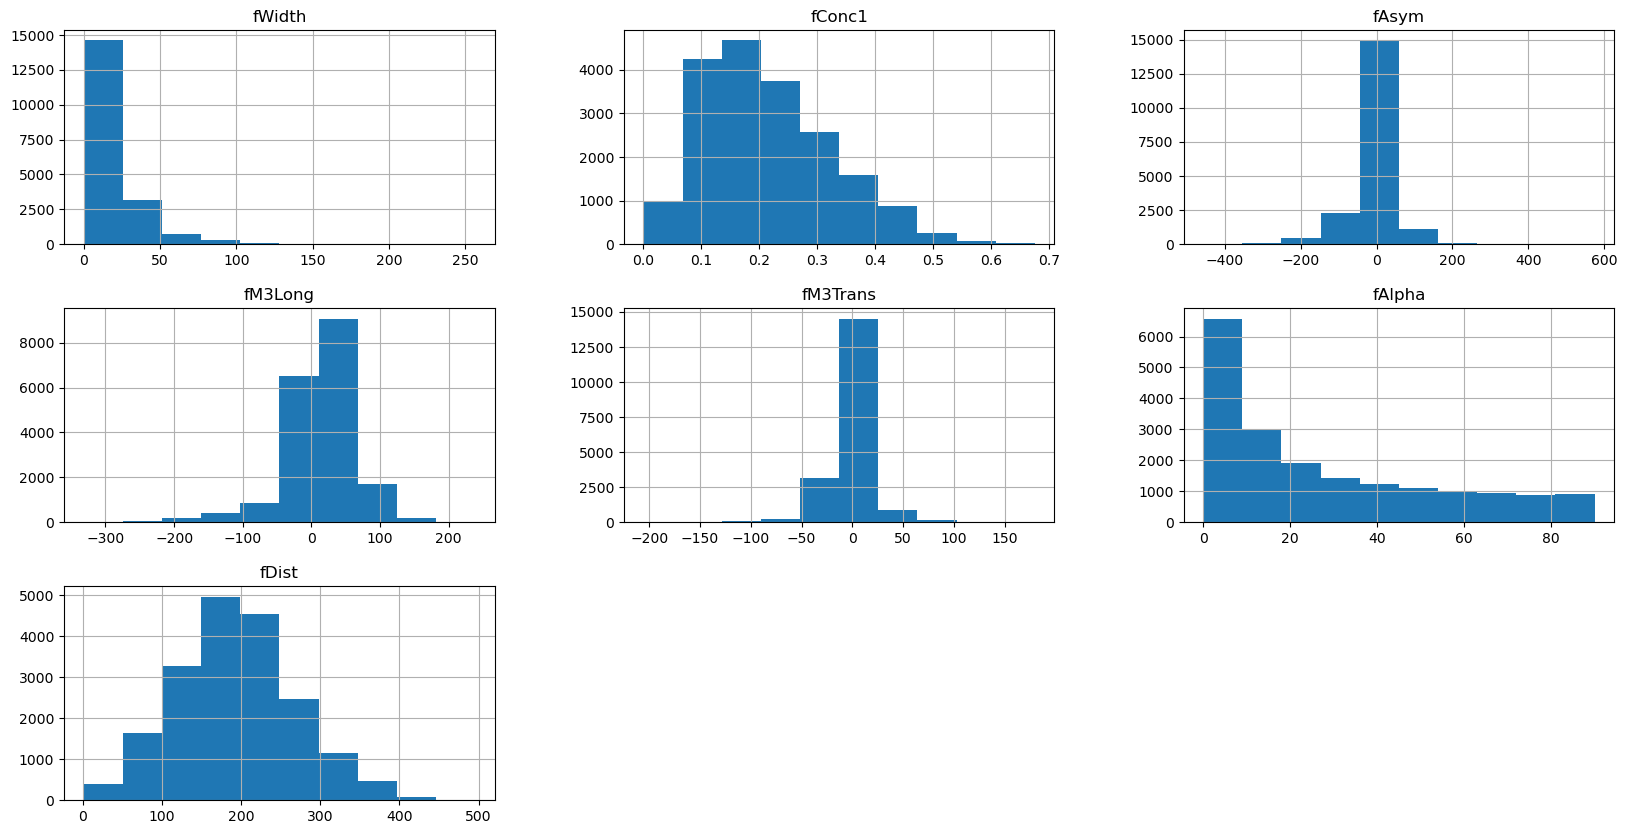

In [11]:
X.hist(figsize=(20,10));

In [12]:
df = pd.concat([X.copy(),data['class']],axis=1)
df

,fWidth,fConc1,fAsym,fM3Long,fM3Trans,fAlpha,fDist,class
0,16.0021,0.1982,27.7004,22.0110,-8.2027,40.0920,81.8828,0
1,11.7235,0.3773,26.2722,23.8238,-9.9574,6.3609,205.2610,0
2,136.0310,0.0187,116.7410,-64.8580,-45.2160,76.9600,256.7880,0
3,9.5728,0.3922,27.2107,-6.4633,-7.1513,10.4490,116.7370,0
4,30.9205,0.1832,-5.5277,28.5525,21.8393,4.6480,356.4620,0
...,...,...,...,...,...,...,...,...
19015,10.9170,0.3934,15.2618,11.5245,2.8766,2.4229,106.8258,1
19016,6.7020,0.2784,37.0816,13.1853,-2.9632,86.7975,247.4560,1
19017,47.5305,0.0549,-9.3561,41.0562,-9.4662,30.2987,256.5166,1
19018,76.9018,0.0683,5.8043,-93.5224,-63.8389,84.6874,408.3166,1


In [13]:
df.skew()

fWidth      3.371628
fConc1      0.685695
fAsym      -1.046441
fM3Long    -1.123078
fM3Trans    0.120121
fAlpha      0.850890
fDist       0.229587
class       0.621522
dtype: float64

In [14]:
df.kurtosis()

fWidth      16.765407
fConc1       0.029391
fAsym        8.155330
fM3Long      4.670974
fM3Trans     8.580352
fAlpha      -0.533704
fDist       -0.112577
class       -1.613880
dtype: float64

## Data splitting in train and test sets & scaling

In [15]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PowerTransformer
transformer=PowerTransformer(standardize=False)

In [16]:
X_train, X_test, Y_train, Y_test = train_test_split(df.iloc[:,:-1], df['class'],train_size=0.7, test_size=0.3, random_state=0, stratify=df['class'])


In [17]:
X_train_transformed = X_train.copy()
X_test_transformed = X_test.copy()


In [18]:
X_train_transformed[['fWidth', 'fConc1', 'fM3Long']] = transformer.fit_transform(X_train_transformed[['fWidth', 'fConc1', 'fM3Long']])

X_test_transformed[['fWidth', 'fConc1', 'fM3Long']] = transformer.transform(X_test_transformed[['fWidth', 'fConc1', 'fM3Long']])



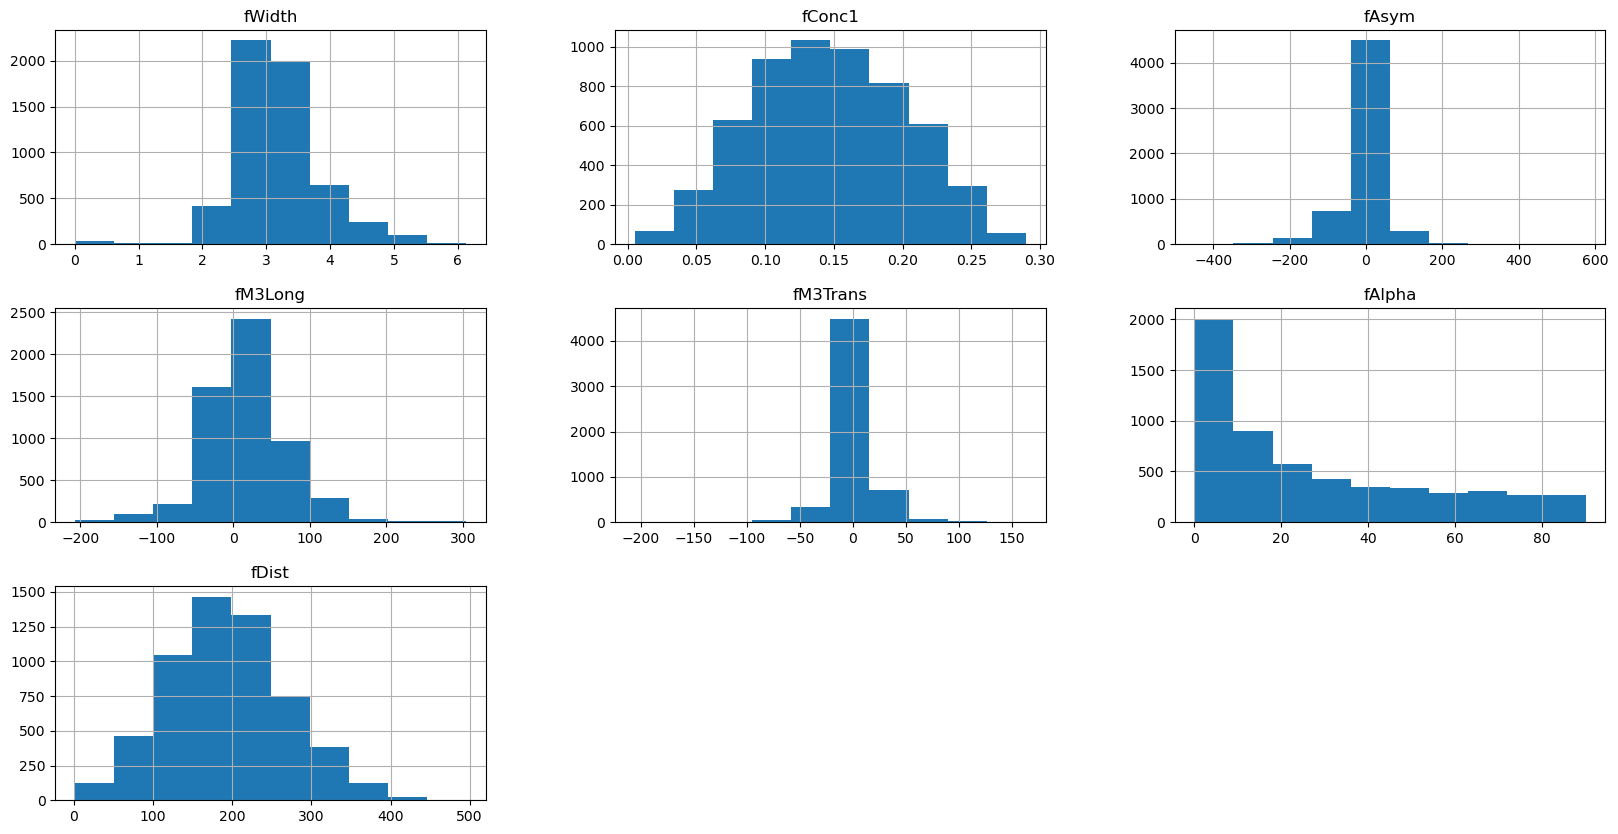

In [19]:
X_test_transformed.hist(figsize=(20,10));

In [20]:
scaler = StandardScaler()

In [21]:
X_train_transformed = pd.DataFrame(scaler.fit_transform(X_train_transformed),columns=['fWidth','fConc1','fAsym','fM3Long','fM3Trans','fAlpha','fDist'])
X_test_transformed = pd.DataFrame(scaler.transform(X_test_transformed),columns=['fWidth','fConc1','fAsym','fM3Long','fM3Trans','fAlpha','fDist'])

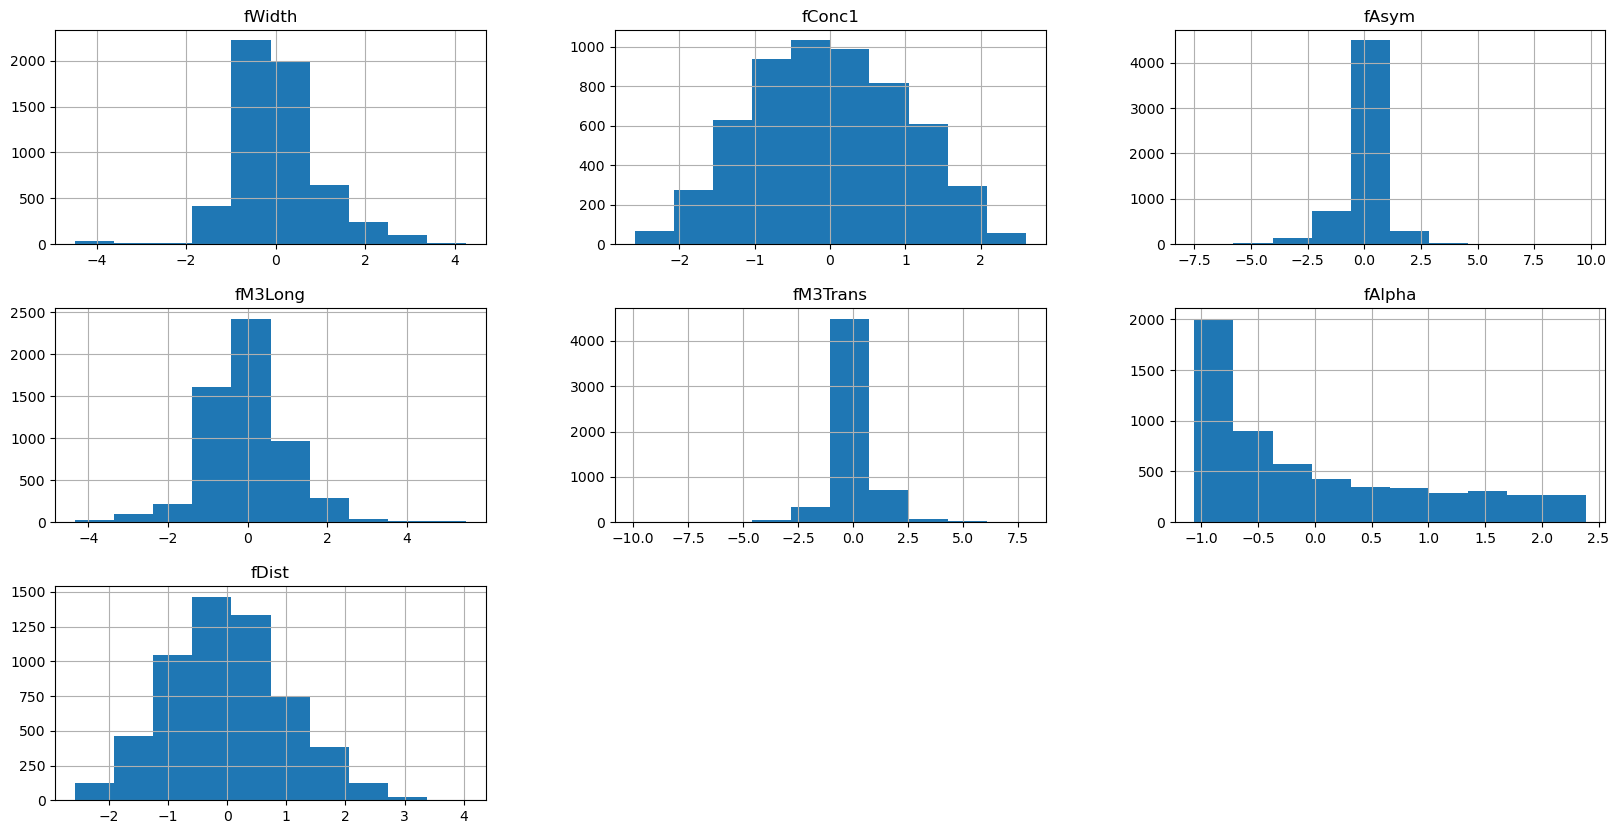

In [22]:
X_test_transformed.hist(figsize=(20,10));

In [23]:
model1 = LogisticRegression(random_state=0)
model1.fit(X_train_transformed,Y_train)
Yhat1_train = model1.predict(X_train_transformed)
Yhat1_test = model1.predict(X_test_transformed)



In [24]:
metrics_data_test = {
    'Accuracy': accuracy_score(Y_test,Yhat1_test),
    'Recall': recall_score(Y_test, Yhat1_test),
    'Precision': precision_score(Y_test, Yhat1_test),
    'F1 Score': f1_score(Y_test, Yhat1_test),
    'Roc_Auc Score': roc_auc_score(Y_test, Yhat1_test),
}

metrics_data_test

{'Accuracy': 0.7655099894847529,
 'Recall': 0.5363908275174477,
 'Precision': 0.7250673854447439,
 'F1 Score': 0.6166189111747852,
 'Roc_Auc Score': 0.7130602786235888}

In [25]:
metrics_data_train = {
    'Accuracy': accuracy_score(Y_train,Yhat1_train),
    'Recall': recall_score(Y_train, Yhat1_train),
    'Precision': precision_score(Y_train, Yhat1_train),
    'F1 Score': f1_score(Y_train, Yhat1_train),
    'Roc_Auc Score': roc_auc_score(Y_train, Yhat1_train),
}

metrics_data_train

{'Accuracy': 0.7703920684993241,
 'Recall': 0.5459205467748826,
 'Precision': 0.7330083166045311,
 'F1 Score': 0.6257803892765332,
 'Roc_Auc Score': 0.7190330259360974}

In [26]:
Y_train[Y_train==1].count()/Y_train.count()

0.3516599068649542

In [27]:
from imblearn.over_sampling import SMOTE

# Crear una instancia del SMOTE
smote = SMOTE(random_state=0)  # Aquí puedes ajustar la proporción deseada

# Aplicar SMOTE a tus datos
X_resampled, Y_resampled = smote.fit_resample(X_train_transformed, Y_train)

In [28]:
Y_resampled[Y_resampled==1].count()/Y_resampled.count()

0.5

In [29]:
model2 = LogisticRegression(random_state=0)
model2.fit(X_resampled,Y_resampled)
Yhat2_train = model2.predict(X_resampled)
Yhat2_test = model2.predict(X_test_transformed)



In [30]:
metrics_data_train_2 = {
    'Accuracy': accuracy_score(Y_resampled,Yhat2_train),
    'Recall': recall_score(Y_resampled, Yhat2_train),
    'Precision': precision_score(Y_resampled, Yhat2_train),
    'F1 Score': f1_score(Y_resampled, Yhat2_train),
    'Roc_Auc Score': roc_auc_score(Y_resampled, Yhat2_train),
}

metrics_data_train_2

{'Accuracy': 0.7544022242817423,
 'Recall': 0.7003012048192772,
 'Precision': 0.7852689010132502,
 'F1 Score': 0.7403551745254134,
 'Roc_Auc Score': 0.7544022242817423}

In [31]:
metrics_data_test_2 = {
    'Accuracy': accuracy_score(Y_test,Yhat2_test),
    'Recall': recall_score(Y_test, Yhat2_test),
    'Precision': precision_score(Y_test, Yhat2_test),
    'F1 Score': f1_score(Y_test, Yhat2_test),
    'Roc_Auc Score': roc_auc_score(Y_test, Yhat2_test),
}

metrics_data_test_2

{'Accuracy': 0.7747984577637574,
 'Recall': 0.6984047856430707,
 'Precision': 0.6732340221047574,
 'F1 Score': 0.6855884511866895,
 'Roc_Auc Score': 0.7573105009296435}

In [32]:
from sklearn.metrics import confusion_matrix

# Calcula la matriz de confusión
cm = confusion_matrix(Y_train, Yhat1_train)

# Convierte la matriz de confusión en un DataFrame de Pandas
cm_df = pd.DataFrame(cm, index=["Clase 0", "Clase 1"], columns=["Clase 0 Predicha", "Clase 1 Predicha"])

cm_df

,Clase 0 Predicha,Clase 1 Predicha
Clase 0,7701,931
Clase 1,2126,2556


In [33]:
cm2 = confusion_matrix(Y_test, Yhat1_test)

# Convierte la matriz de confusión en un DataFrame de Pandas
cm_df_t = pd.DataFrame(cm2, index=["Clase 0", "Clase 1"], columns=["Clase 0 Predicha", "Clase 1 Predicha"])

cm_df_t


,Clase 0 Predicha,Clase 1 Predicha
Clase 0,3292,408
Clase 1,930,1076


In [34]:
cm3 = confusion_matrix(Y_test, Yhat2_test)

# Convierte la matriz de confusión en un DataFrame de Pandas
cm_df_t = pd.DataFrame(cm3, index=["Clase 0", "Clase 1"], columns=["Clase 0 Predicha", "Clase 1 Predicha"])

cm_df_t


,Clase 0 Predicha,Clase 1 Predicha
Clase 0,3020,680
Clase 1,605,1401
